In [1]:
import sys
# !{sys.executable} -m pip install torch torchvision torchaudio
import lightgbm as lgb
import xgboost

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler


# Torch
import torch
print(torch.__version__,torch.__path__)
import torch.nn as nn

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


2.1.0 ['/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch']
Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 400

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
# Find set of files
monomerfiles=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
co2files=glob('./dipeptides_co2_coordinates/AA_AA_*/final.xyz')
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles]

y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","")) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)

In [3]:
AAs=list(set(sum([i[0].split('-') for i in pairs.values],[])))

In [4]:
len(AAs)

20

In [5]:
AAs

['Glycine',
 'Arginine',
 'Aspartic',
 'Alanine',
 'Threonine',
 'Phenylalanine',
 'Leucine',
 'Lysine',
 'Histidine',
 'Cysteine',
 'Glutamine',
 'Methionine',
 'Tryptophan',
 'Serine',
 'Glutamic',
 'Proline',
 'Asparagine',
 'Valine',
 'Tyrosine',
 'Isoleucine']

In [5]:
ValSer=Chem.MolFromSmiles(list(pybel.readfile('xyz','./dipeptides_coordinates/AA_AA_396/final.xyz'))[0].write().split('\t')[0])

In [6]:
SerVal=Chem.MolFromSmiles(list(pybel.readfile('xyz','./dipeptides_coordinates/AA_AA_320/final.xyz'))[0].write().split('\t')[0])

In [7]:
[(u,v) for u,v in list(zip(MACCSkeys.GenMACCSKeys(ValSer).ToList(),MACCSkeys.GenMACCSKeys(SerVal).ToList())) if u!=v]

[(0, 1)]

In [8]:
DataStructs.TanimotoSimilarity(MACCSkeys.GenMACCSKeys(ValSer),MACCSkeys.GenMACCSKeys(SerVal))

0.9714285714285714

In [9]:
# img=Draw.MolsToGridImage([ValSer,SerVal],molsPerRow=2, subImgSize=(300,300))

# Draw.MolToImage(ValSer).save('ValSer.png')
# Draw.MolToImage(SerVal).save('SerVal.png')

In [10]:
pairs[pairs[1]=='Valine-Serine']

,1
0,
AA_AA_396,Valine-Serine


In [11]:
pairs[pairs[1]=='Serine-Valine']

,1
0,
AA_AA_320,Serine-Valine


In [12]:
dfpairE=pd.DataFrame(np.zeros((20,20)),index=AAs,columns=AAs)
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    dfpairE[names[0]][names[1]]=y.set_index('keypair').loc[k].values

In [13]:
devpairs=pd.DataFrame(sum([[('-'.join((i,j)),abs(dfpairE[i][j]-dfpairE[j][i])) for idxi,i in enumerate(AAs) if idxj>idxi] for idxj,j in enumerate(AAs)],[]),columns=['Pairs','Deviation'])

In [44]:
len(devpairs[devpairs['Deviation']<=1])/len(devpairs)

0.6578947368421053

,Pairs,Deviation
0,Threonine-Arginine,0.168051
1,Threonine-Isoleucine,0.065879
2,Arginine-Isoleucine,2.078773
3,Threonine-Glutamine,0.574229
4,Arginine-Glutamine,0.807160
...,...,...
185,Tyrosine-Histidine,1.140237
186,Lysine-Histidine,0.268381
187,Proline-Histidine,1.337652
188,Serine-Histidine,0.215965


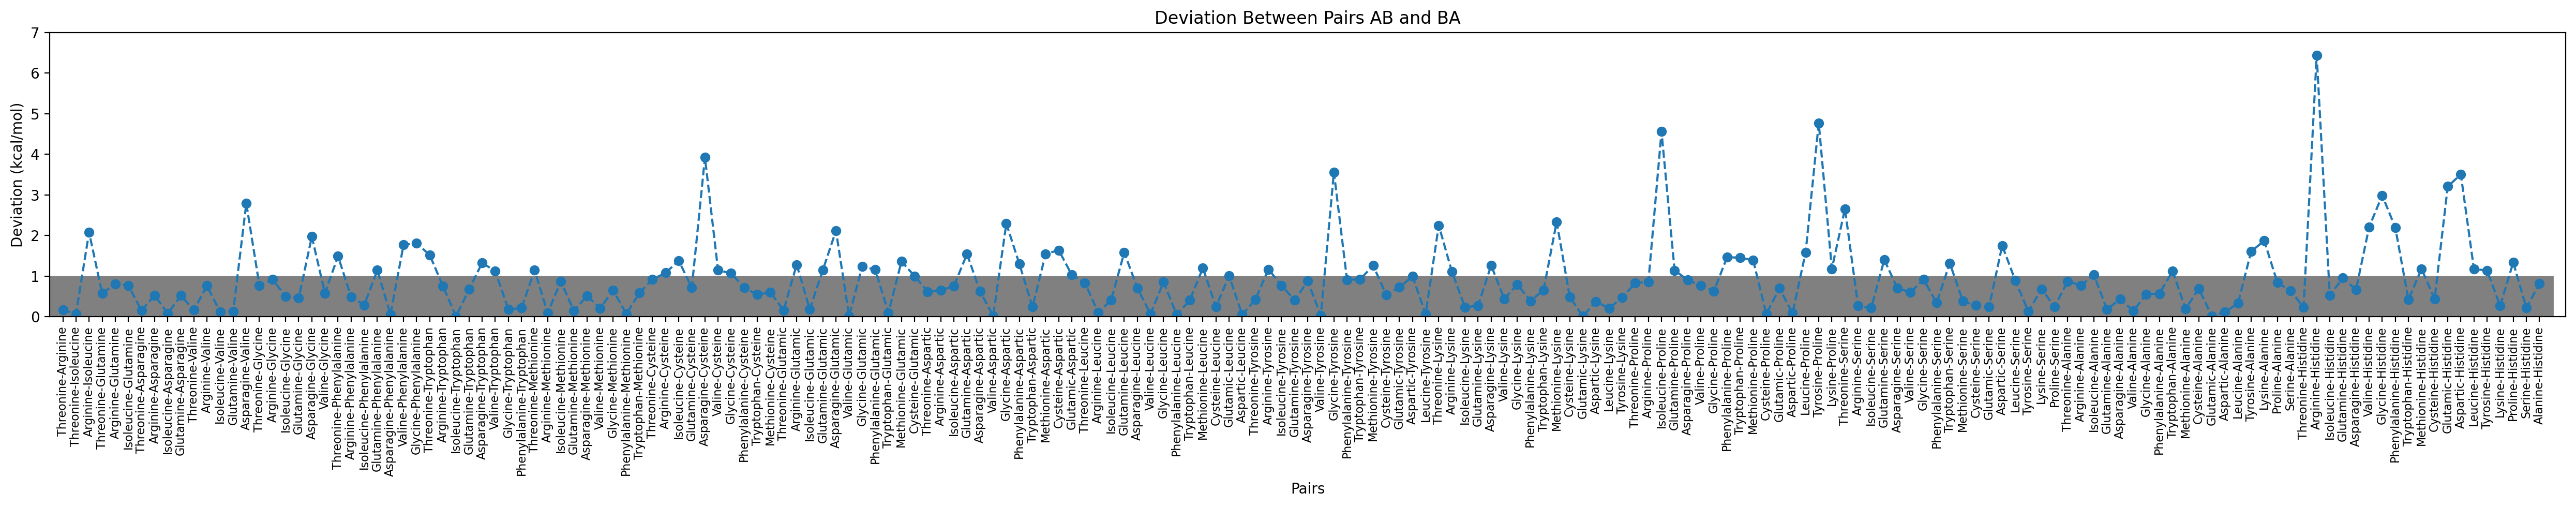

In [15]:
plt.figure(figsize=(25,5))
# sns.lineplot(data=devpairs,x='Pairs',y='Deviation')
plt.plot(range(len(devpairs['Pairs'])),devpairs['Deviation'],'o--')

plt.fill_between(np.arange(-1,len(devpairs['Pairs'])+1)*[1],np.zeros(len(devpairs['Pairs'])+2),np.ones(len(devpairs['Pairs'])+2),color='gray')
plt.xticks(range(len(devpairs['Pairs'])),devpairs['Pairs'],rotation=90, fontsize = 8)
plt.xlim(-1,len(devpairs)+1)
plt.ylim(0,7)
plt.xlabel('Pairs')
plt.ylabel('Deviation (kcal/mol)')
plt.title('Deviation Between Pairs AB and BA')
plt.tight_layout()
plt.savefig('absolute_pair_dev.png',dpi=300,bbox_inches='tight')
plt.show()

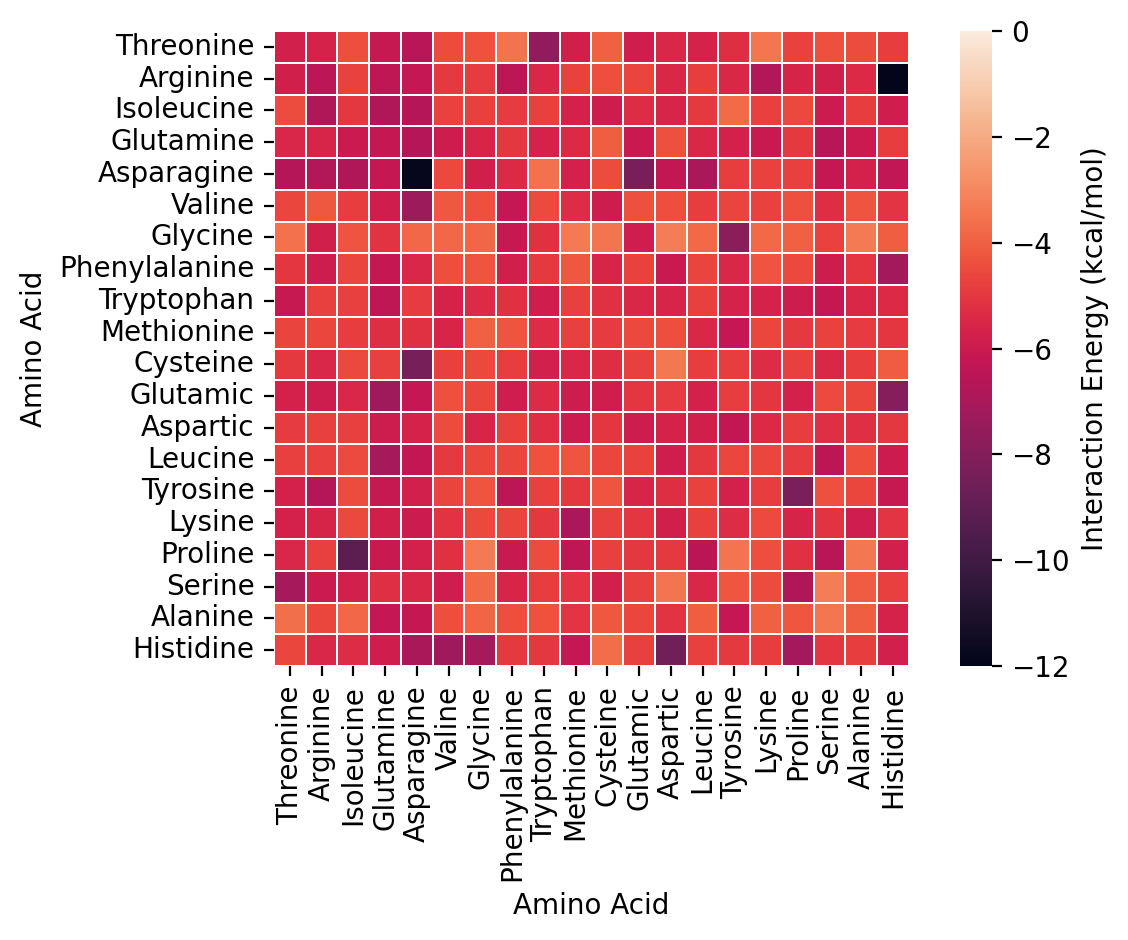

In [16]:
sns.heatmap(data=dfpairE,vmin=-12,vmax=0,cbar_kws={'label': 'Interaction Energy (kcal/mol)'},linewidths=0.1,square=True)
plt.xlabel('Amino Acid')
plt.ylabel('Amino Acid')

plt.tight_layout()
plt.savefig('pair_heat.png',dpi=300,bbox_inches='tight')
plt.show()

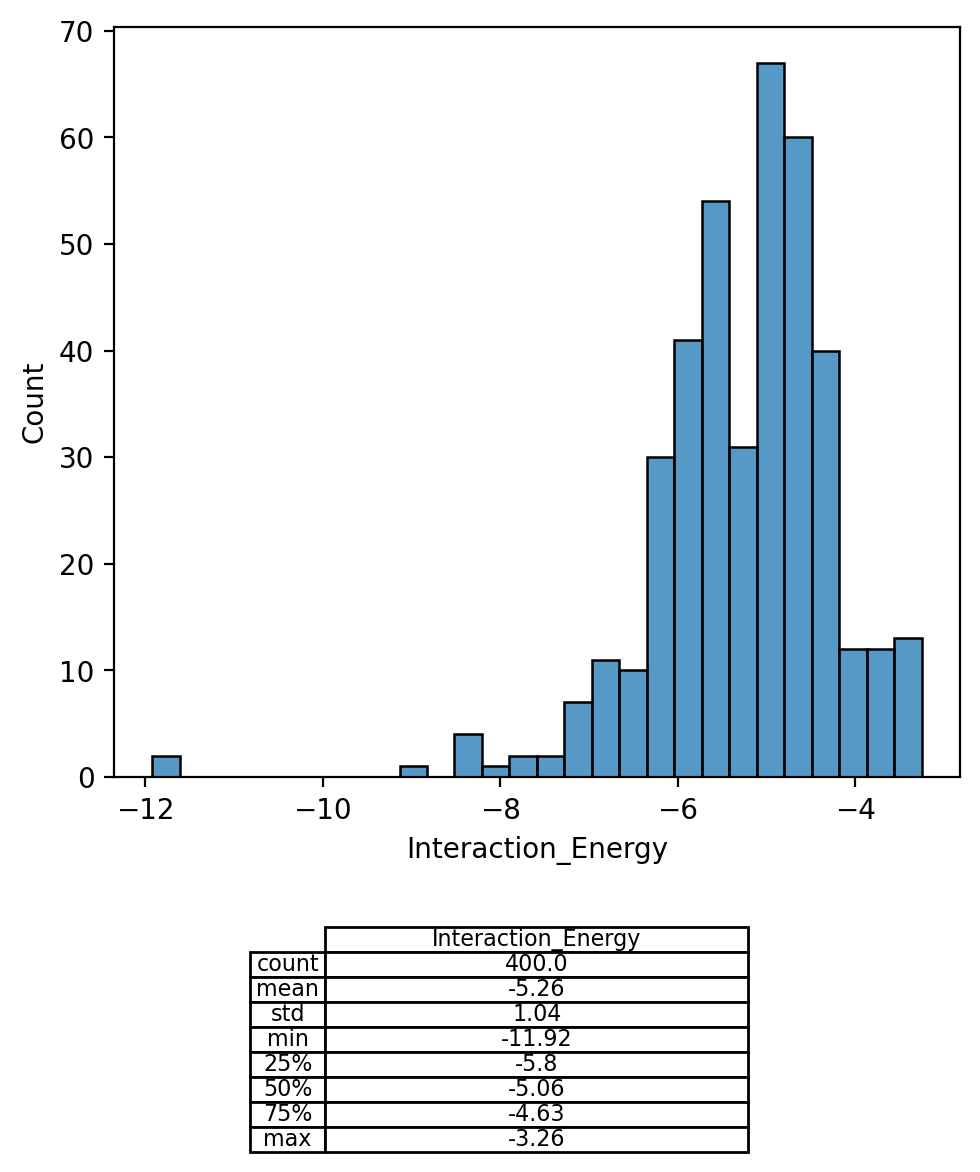

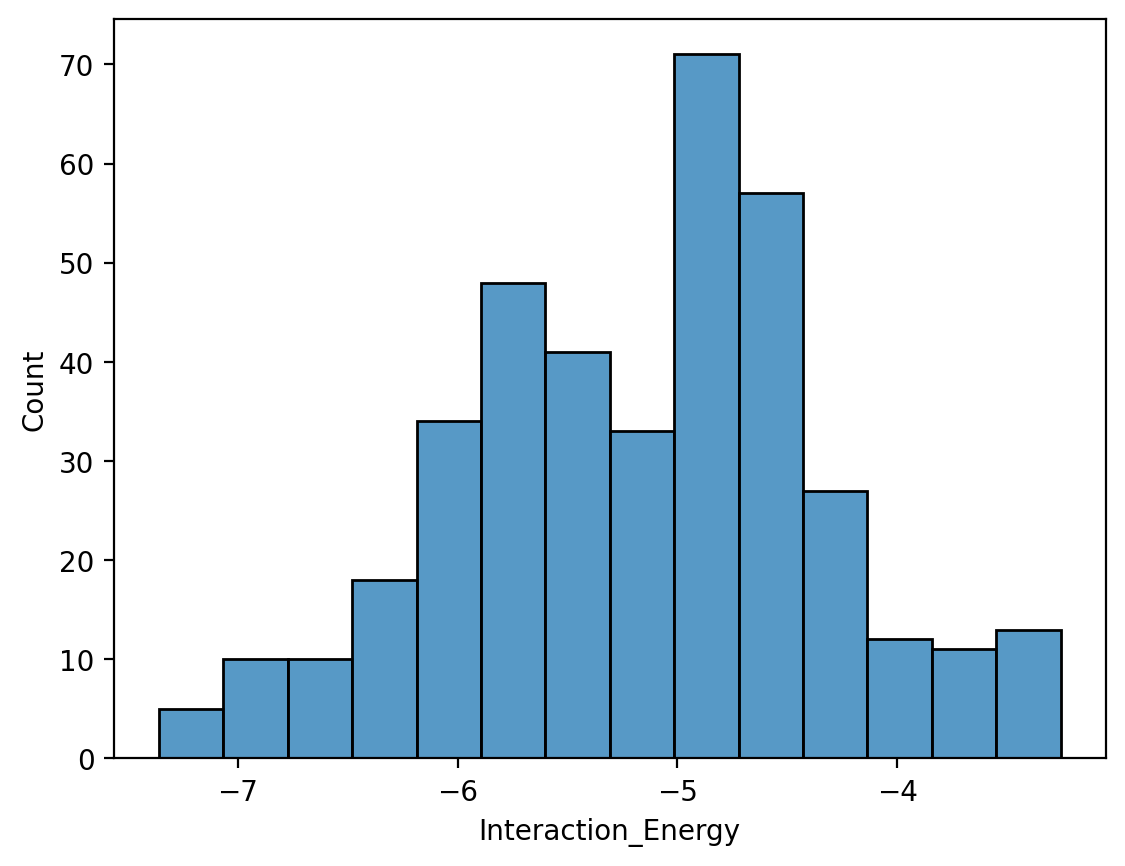

In [17]:
stats=pd.DataFrame(y['Interaction_Energy'].describe()).round(2)

plt.figure(figsize=(5,5))
sns.histplot(data=y,x='Interaction_Energy')
table =plt.table(cellText=stats.values,
          rowLabels=stats.index,
          colLabels=stats.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='bottom', bbox=[0.25, -0.5, 0.5, 0.3])


table.auto_set_font_size(False)
table.set_fontsize(8)


plt.subplots_adjust(left=0, bottom=0.5)
plt.tight_layout()
plt.savefig('spread.png',dpi=300,bbox_inches='tight')
plt.show()

Q1=y['Interaction_Energy'].quantile(0.25)
Q3=y['Interaction_Energy'].quantile(0.75)
IQR=Q3-Q1
upper = Q3 + 1.5*IQR

lower = Q1 - 1.5*IQR

y=y[(y['Interaction_Energy']>=lower)&(y['Interaction_Energy']<=upper)].dropna()
sns.histplot(data=y,x='Interaction_Energy')
plt.show()

In [18]:
bitkey=dict(zip(AAs,range(len(AAs))))

In [19]:
bitkey

{'Threonine': 0,
 'Arginine': 1,
 'Isoleucine': 2,
 'Glutamine': 3,
 'Asparagine': 4,
 'Valine': 5,
 'Glycine': 6,
 'Phenylalanine': 7,
 'Tryptophan': 8,
 'Methionine': 9,
 'Cysteine': 10,
 'Glutamic': 11,
 'Aspartic': 12,
 'Leucine': 13,
 'Tyrosine': 14,
 'Lysine': 15,
 'Proline': 16,
 'Serine': 17,
 'Alanine': 18,
 'Histidine': 19}

In [20]:
samples=len(y)
X=np.zeros((samples,len(AAs)))
Y=np.zeros((samples,1))

for idx,(k,v) in enumerate(y.set_index('keypair').to_dict()['Interaction_Energy'].items()):
    aa=pairs.loc[k].values[0].split('-')
    a1=aa[0]
    a2=aa[1]
    if a1!=a2:
        X[idx,bitkey[a1]]=1
        X[idx,bitkey[a2]]=1
    else:
        X[idx,bitkey[a1]]=2
    Y[idx]=v

In [21]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [22]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [23]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [24]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))

In [25]:
# help(Draw.MolsToGridImage)

In [26]:
stats

,Interaction_Energy
count,400.00
mean,-5.26
std,1.04
min,-11.92
25%,-5.80
50%,-5.06
75%,-4.63
max,-3.26


In [27]:
# # Intersection of the two sets
# intersection=set(['_'.join(i.split('_')[:3]) for i in list(y.index)]) & set(co2check)&set(moncheck)
# X=genpaddedCMs(intersection)
# Y=y.loc[sum([[i for i in y.index if j=='_'.join(i.split('_')[:3])] for j in intersection],[])].to_numpy().reshape(-1)

In [28]:


# ptable = fetch_table('elements').set_index('symbol')
# Z=ptable['atomic_number']

# atomLabels = {v:k for k,v in Z.to_dict().items()}

# Elementlist=list(Z.index)


# def speciescheck(files):
#     return np.unique(np.hstack([np.genfromtxt(m,skip_header=2,dtype=str,usecols=0) for m in files]))

# # species = speciescheck(foldername)
# rcut = 8.0
# nmax = 6
# lmax = 6
# species=speciescheck(monomerfiles)
# # Setting up the SOAP descriptor
# soap = SOAP(
#     species=species,
#     periodic=False,
#     rcut=rcut,
#     nmax=nmax,
#     lmax=lmax,
#     sigma=1.5
# )

# soaplist=list()



# files=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
# samples=len(y)
# Y=np.zeros((samples,1))

# for idx,i in enumerate(y.index):
#     nam='_'.join(i.split('_')[:3])
#     filename=f"./dipeptides_coordinates/{nam}/final.xyz"
#     atoms=read(filename)
#     soaplist.append(normalize(soap.create(atoms)))
#         #soaplist.append(normalize(soap.create(atoms)))
#     Y[idx,:]=y.loc[i].values
    
    

# re = REMatchKernel(metric="rbf", gamma=2, alpha=1.2, threshold=1e-8, normalize_kernel=False)
# X = re.create(soaplist)

In [29]:

# pixelsx=20
# pixelsy=20
# spread=.01
# Max=2.5


# files=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
# # files=glob('./dipeptides_co2_coordinates/AA_AA_*/final.xyz')

# samples=len(y)
# X=np.zeros((samples,pixelsx*pixelsy))
# Y=np.zeros((samples,1))
# for idx,i in enumerate(y.index):
#     nam='_'.join(i.split('_')[:3])
#     filename=f"./dipeptides_coordinates/{nam}/final.xyz"
#     if os.path.exists(os.path.join(os.getcwd(),filename)):
#         X[idx,:]=VariancePersist(Filename = filename, pixelx=pixelsx, pixely=pixelsy, myspread=spread, myspecs={"maxBD": Max, "minBD":-0.1}, showplot=False)
#         Y[idx,:]=y['Interaction_Energy'].loc[i]

In [30]:
print(X.shape,Y.shape)

(390, 20) (390, 1)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.reshape(-1,), test_size=0.3, random_state=42)

In [32]:
# from sklearn.feature_selection import VarianceThreshold
# # sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
# transformer=MinMaxScaler()
# X_train=transformer.fit_transform(X_train)
# X_test=transformer.transform(X_test)

In [33]:
# model=KernelRidge(alpha=0.01, gamma=0.01, kernel='laplacian').fit(X_train,y_train)
parameters = {'kernel': ['rbf','laplacian'],'alpha':np.logspace(-6,6,7),'gamma':np.logspace(-6,6,7)}
GridSearch = GridSearchCV(KernelRidge(),param_grid=parameters,cv=5,verbose=0,n_jobs=-1,scoring='r2').fit(X_train,y_train)
model=GridSearch.best_estimator_.fit(X_train,y_train)




train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

stats={'Train':len(X_train),
       'Test':len(X_test),
       'Train MAPE':mean_absolute_percentage_error(y_train,train_pred)*100,
       'Test MAPE':mean_absolute_percentage_error(y_test,test_pred)*100,
       'Train R2':r2_score(y_train,train_pred),
       'Test R2':r2_score(y_test,test_pred),
       'Train MAE':mean_absolute_error(y_train,train_pred),
       'Test MAE':mean_absolute_error(y_test,test_pred),
       'Train RMSE':mean_squared_error(y_train,train_pred, squared=False),
       'Test RMSE':mean_squared_error(y_test,test_pred, squared=False)}

In [34]:
stats

{'Train': 273,
 'Test': 117,
 'Train MAPE': 11.012931467777806,
 'Test MAPE': 11.51247817252045,
 'Train R2': 0.3291067783863779,
 'Test R2': 0.19581764243996547,
 'Train MAE': 0.5571342784143883,
 'Test MAE': 0.5451609606842822,
 'Train RMSE': 0.7007014276644995,
 'Test RMSE': 0.6576354623535593}

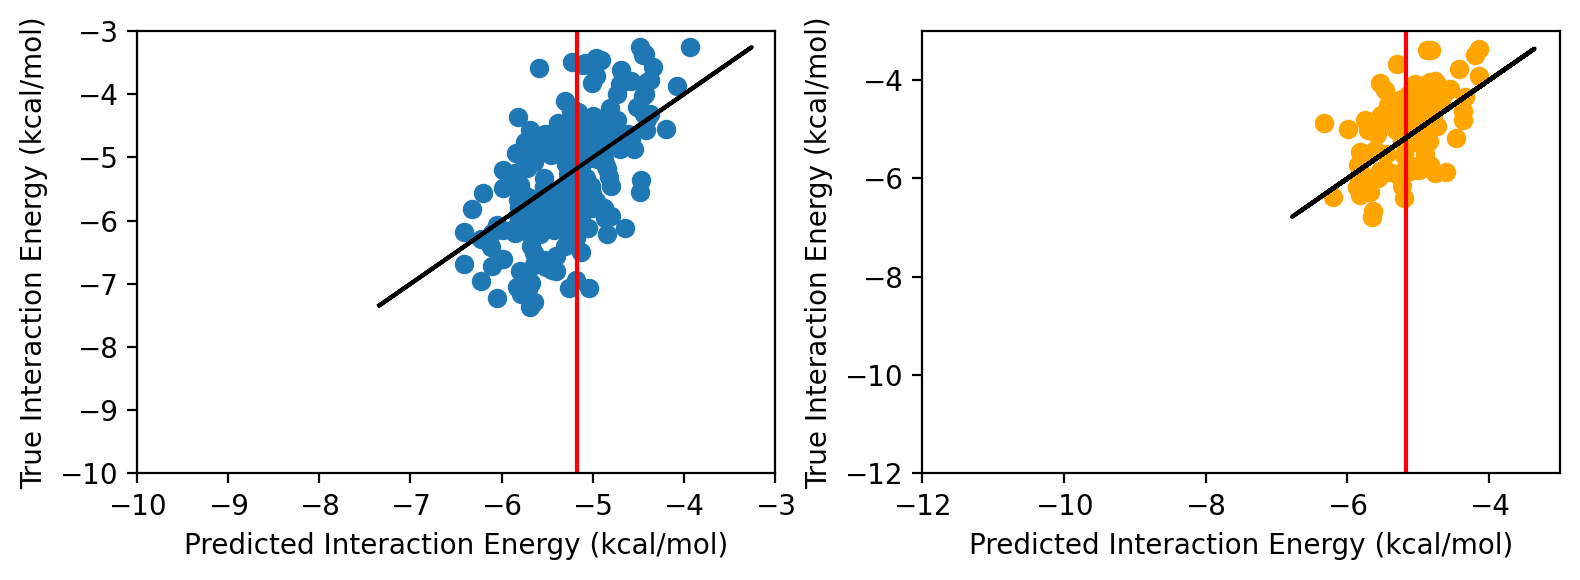

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(8,3))
ax1.scatter(train_pred,y_train)
ax1.vlines(y['Interaction_Energy'].mean(),-15,0,color='red')
ax1.plot(y_train,y_train,'k')
ax1.set_ylim(-10,-3)
ax1.set_xlim(-10,-3)
ax1.set_ylabel('True Interaction Energy (kcal/mol)')
ax1.set_xlabel('Predicted Interaction Energy (kcal/mol)')


ax2.scatter(test_pred,y_test,color='orange')
ax2.vlines(y['Interaction_Energy'].mean(),-15,0,color='red')
ax2.plot(y_test,y_test,'k')
ax2.set_ylabel('True Interaction Energy (kcal/mol)')
ax2.set_xlabel('Predicted Interaction Energy (kcal/mol)')
ax2.set_xlim(-12,-3)
ax2.set_ylim(-12,-3)
plt.tight_layout()
plt.show()

In [36]:
class ANN(nn.Module):    
    def __init__(self,featdim):
        super(ANN,self).__init__()                
        self.out=torch.nn.Sequential( 
            torch.nn.Linear(featdim,featdim),
            torch.nn.ELU(),
            torch.nn.Linear(featdim,2*featdim),
            torch.nn.ELU(),
            torch.nn.Linear(2*featdim,2*featdim),
            torch.nn.ELU(),
            torch.nn.Linear(2*featdim,2*featdim),
            torch.nn.ELU(),            
            torch.nn.Linear(2*featdim,featdim),
            torch.nn.ELU(),
            torch.nn.Linear(featdim, 1,bias=False)
        )  
    def forward(self,x):
        return self.out(x)

In [37]:
X_train=torch.FloatTensor(X_train)
y_train=torch.FloatTensor(y_train)

X_test=torch.FloatTensor(X_test)
y_test=torch.FloatTensor(y_test)

model =ANN(X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss=torch.nn.MSELoss()



epoch=0  

t0=perf_counter()
train_losslst=[]
test_losslst=[]
for epoch in range(10000):
    pred = model(X_train)
    loss = mse_loss(pred, y_train)
                    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    # update weights
    optimizer.step()
    GR_train_acc=loss.detach().item()
    train_losslst.append(np.sqrt(GR_train_acc))
    with torch.no_grad():  
        pred_test=model(X_test)
        test_loss=mse_loss(pred_test, y_test)
        GR_test_acc=test_loss.detach().item()
        test_losslst.append(np.sqrt(GR_test_acc))
    if (epoch%100)==0:
        print(f'Epoch {epoch+1} finished in {perf_counter()-t0:.4f} (s) Train loss: {np.sqrt(GR_train_acc):0.4e} kcal/mol Test loss: {np.sqrt(GR_test_acc):0.4e} kcal/mol')

with torch.no_grad():
    predtrain, predtest=model(X_train), model(X_test)


/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([273])) that is different to the input size (torch.Size([273, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([117])) that is different to the input size (torch.Size([117, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 finished in 0.0118 (s) Train loss: 5.2959e+00 kcal/mol Test loss: 5.0230e+00 kcal/mol
Epoch 101 finished in 0.1432 (s) Train loss: 5.0309e+00 kcal/mol Test loss: 4.7543e+00 kcal/mol
Epoch 201 finished in 0.2696 (s) Train loss: 4.0023e+00 kcal/mol Test loss: 3.7099e+00 kcal/mol
Epoch 301 finished in 0.3861 (s) Train loss: 1.3362e+00 kcal/mol Test loss: 1.0599e+00 kcal/mol
Epoch 401 finished in 0.5014 (s) Train loss: 8.9469e-01 kcal/mol Test loss: 8.2081e-01 kcal/mol
Epoch 501 finished in 0.6178 (s) Train loss: 8.8364e-01 kcal/mol Test loss: 8.0685e-01 kcal/mol
Epoch 601 finished in 0.7379 (s) Train loss: 8.7544e-01 kcal/mol Test loss: 7.9789e-01 kcal/mol
Epoch 701 finished in 0.8545 (s) Train loss: 8.6940e-01 kcal/mol Test loss: 7.9134e-01 kcal/mol
Epoch 801 finished in 0.9712 (s) Train loss: 8.6500e-01 kcal/mol Test loss: 7.8664e-01 kcal/mol
Epoch 901 finished in 1.0847 (s) Train loss: 8.6187e-01 kcal/mol Test loss: 7.8334e-01 kcal/mol
Epoch 1001 finished in 1.1991 (s) Train lo

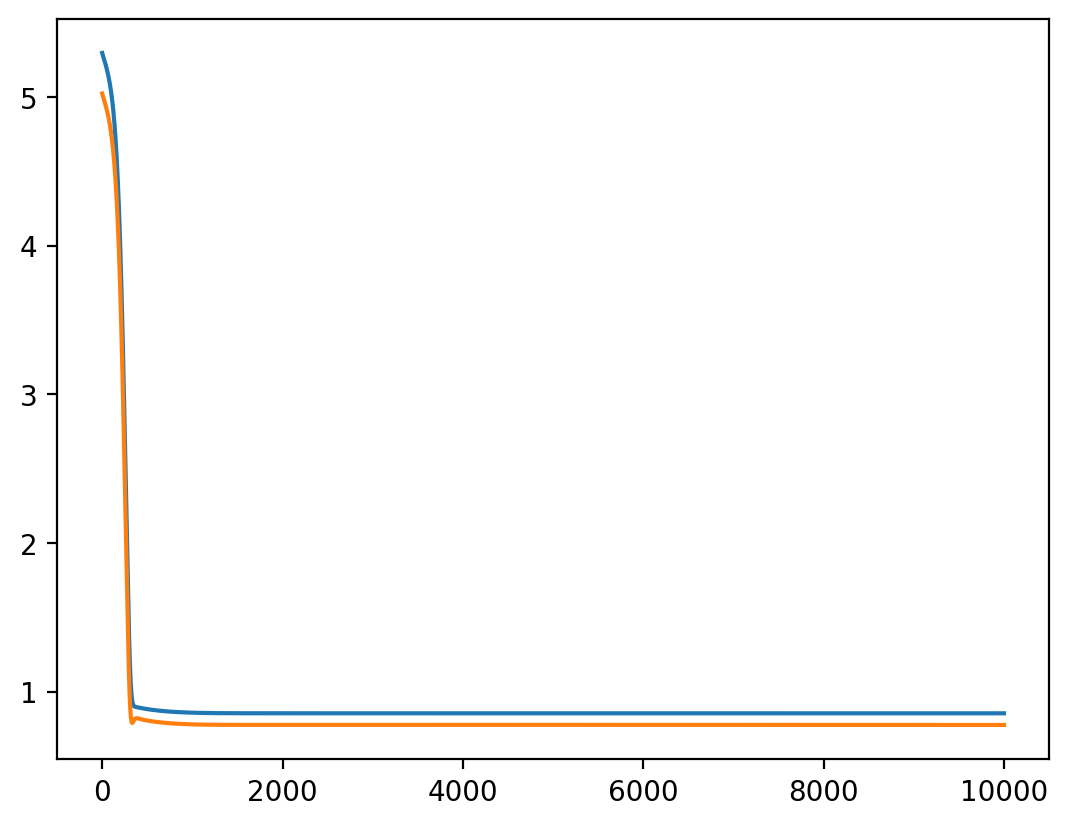

In [38]:
plt.plot(train_losslst)
plt.plot(test_losslst)
plt.show()

/var/folders/df/wnp2kps17hx3h900x0l75f440000gn/T/ipykernel_71547/3873715864.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax1.vlines(y.mean(),-15,0,color='red')
/var/folders/df/wnp2kps17hx3h900x0l75f440000gn/T/ipykernel_71547/3873715864.py:12: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax2.vlines(y.mean(),-15,0,color='red')


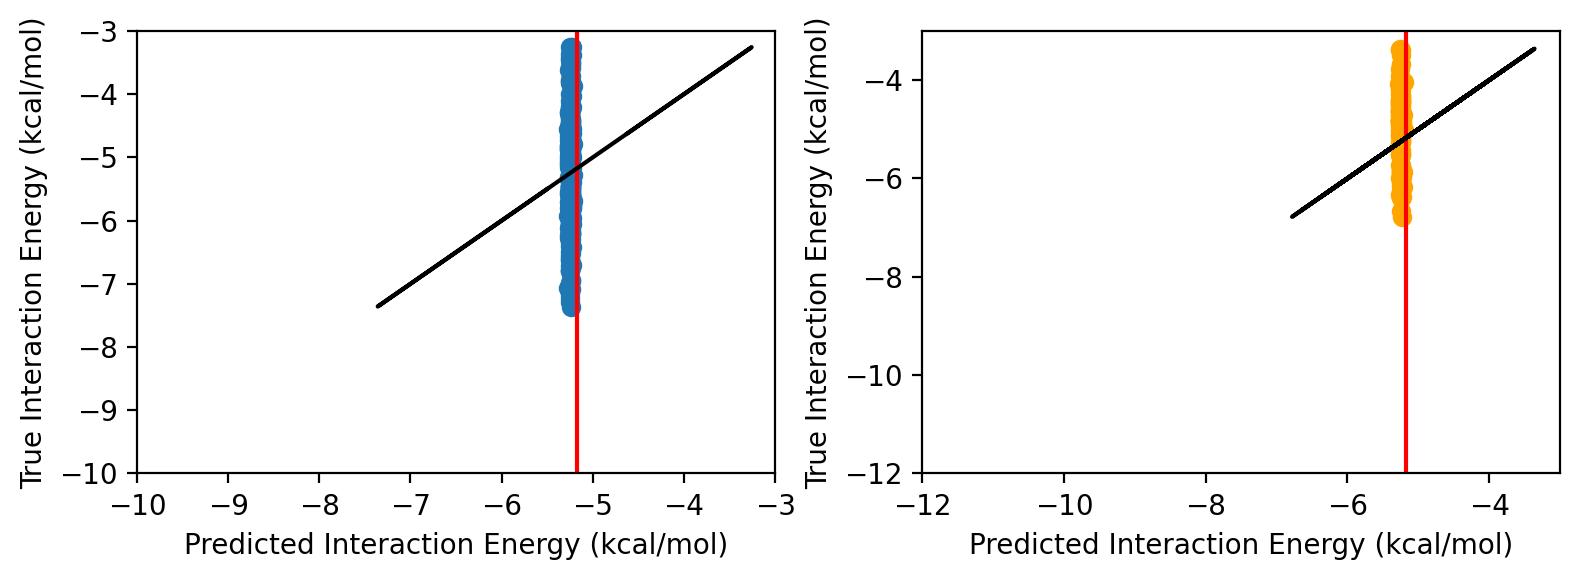

In [39]:

fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(8,3))
ax1.scatter(predtrain,y_train)
ax1.vlines(y.mean(),-15,0,color='red')
ax1.plot(y_train,y_train,'k')
ax1.set_ylim(-10,-3)
ax1.set_xlim(-10,-3)
ax1.set_ylabel('True Interaction Energy (kcal/mol)')
ax1.set_xlabel('Predicted Interaction Energy (kcal/mol)')


ax2.scatter(predtest,y_test,color='orange')
ax2.vlines(y.mean(),-15,0,color='red')
ax2.plot(y_test,y_test,'k')
ax2.set_ylabel('True Interaction Energy (kcal/mol)')
ax2.set_xlabel('Predicted Interaction Energy (kcal/mol)')
ax2.set_xlim(-12,-3)
ax2.set_ylim(-12,-3)
plt.tight_layout()
plt.show()

In [40]:
# parameters = {'learning_rate': np.logspace(-6,-1,6),
#               'n_estimators': np.logspace(0,3,4).astype(int),
#               'reg_alpha':np.logspace(-6,-1,6),
#               'reg_lambda':np.logspace(-6,-1,6)
#              }

# GridSearch = GridSearchCV(xgboost.XGBRegressor(),param_grid=parameters,cv=5,verbose=0,n_jobs=-1).fit(X_train,y_train)
# model=GridSearch.best_estimator_.fit(X_train,y_train)

# # model=xgboost.XGBRegressor(learning_rate=1e-2,n_estimators=10,reg_alpha=1e-3,reg_lambda=1e3,n_jobs=-1).fit(X_train,y_train)


# train_pred=model.predict(X_train)
# test_pred=model.predict(X_test)

# stats={'Train':len(X_train),
#        'Test':len(X_test),
#        'Train MAPE':mean_absolute_percentage_error(y_train,train_pred)*100,
#        'Test MAPE':mean_absolute_percentage_error(y_test,test_pred)*100,
#        'Train R2':r2_score(y_train,train_pred),
#        'Test R2':r2_score(y_test,test_pred),
#        'Train MAE':mean_absolute_error(y_train,train_pred),
#        'Test MAE':mean_absolute_error(y_test,test_pred),
#        'Train RMSE':mean_squared_error(y_train,train_pred, squared=False),
#        'Test RMSE':mean_squared_error(y_test,test_pred, squared=False)}

In [41]:
# stats

In [42]:
# fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(8,3))
# ax1.scatter(train_pred,y_train)
# ax1.vlines(y.mean(),-15,0,color='red')
# ax1.plot(y_train,y_train,'k')
# ax1.set_ylim(-10,-3)
# ax1.set_xlim(-10,-3)
# ax1.set_ylabel('True Interaction Energy (kcal/mol)')
# ax1.set_xlabel('Predicted Interaction Energy (kcal/mol)')


# ax2.scatter(test_pred,y_test,color='orange')
# ax2.vlines(y.mean(),-15,0,color='red')
# ax2.plot(y_test,y_test,'k')
# ax2.set_ylabel('True Interaction Energy (kcal/mol)')
# ax2.set_xlabel('Predicted Interaction Energy (kcal/mol)')
# ax2.set_xlim(-12,-3)
# ax2.set_ylim(-12,-3)
# plt.tight_layout()
# plt.show()